In [1]:
import torch
import torch.nn
import numpy as np
import matplotlib.pyplot as plt

from model import lstm
from dataset import dataset
from training import training


import torch.optim as optim
import tqdm
import os
from importlib import reload
reload(lstm)
reload(dataset)
reload(training)

<module 'training.training' from 'c:\\Users\\Edouard\\github\\DecathlonTest\\training\\training.py'>

# Load Data

In [2]:
ds_train=dataset.Turnover_dataset(None)
ds_val=dataset.Turnover_dataset(None)
with open('./project/train_data.json', 'r') as f:
    ds_train.load_from_json(f)
with open('./project/val_data.json', 'r') as f:
    ds_val.load_from_json(f)

# Model

In [49]:
dep=73
warmup=8
future_prediction=8

In [50]:
ds_train.set_data_for_training(False)
ds_val.set_data_for_training(False)
ds_train.dep=dep
ds_val.dep=dep
dataloader_t = torch.utils.data.DataLoader(ds_train,batch_size=1,shuffle=False,drop_last=False) #Dataloader train set
dataloader_v = torch.utils.data.DataLoader(ds_val,batch_size=1,shuffle=False,drop_last=False) #Dataloader validation set
device= torch.device("cpu")
weights=torch.load("./model_eval/checkpoint_14_{}_{}_{}.pth".format(dep,warmup,future_prediction),map_location=torch.device('cpu'))['model_state_dict']
model = lstm.LSTM_Turnover(False,hidden_size=64,num_of_layer=4).to(device)
model.load_state_dict(weights)
model.eval()

LSTM_Turnover(
  (lstm_cells): ModuleList(
    (0): LSTMCell(2, 64)
    (1): LSTMCell(64, 64)
    (2): LSTMCell(64, 64)
    (3): LSTMCell(64, 64)
  )
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [51]:
L_t_e=[]
L_v_e=[]
for data in tqdm.tqdm(dataloader_t): #Evaluation on training set
    y=model( data["x"].float().to(device),
            data["annual_x"].float().to(device),
            data["annual_y"].float().to(device),
            8)
    y=y[:,-8:]
    gt=data["y"][:,0:8].float().to(device)
    l1_loss=torch.nn.L1Loss()(y,gt)
    l2_loss=torch.nn.MSELoss()(y,gt)
    L_t_e.append([l1_loss.item(),l2_loss.item()]) #Loss of this batch evaluation
    

for data in tqdm.tqdm(dataloader_v): #Evaluation on training set
    y=model( data["x"].float().to(device),
            data["annual_x"].float().to(device),
            data["annual_y"].float().to(device),
            8)
    y=y[:,-8:]
    gt=data["y"][:,0:8].float().to(device)
    l1_loss=torch.nn.L1Loss()(y,gt)
    l2_loss=torch.nn.MSELoss()(y,gt)
    L_v_e.append([l1_loss.item(),l2_loss.item()])  #Loss of this batch evaluation

 68%|██████▊   | 13466/19905 [03:52<01:54, 56.12it/s]

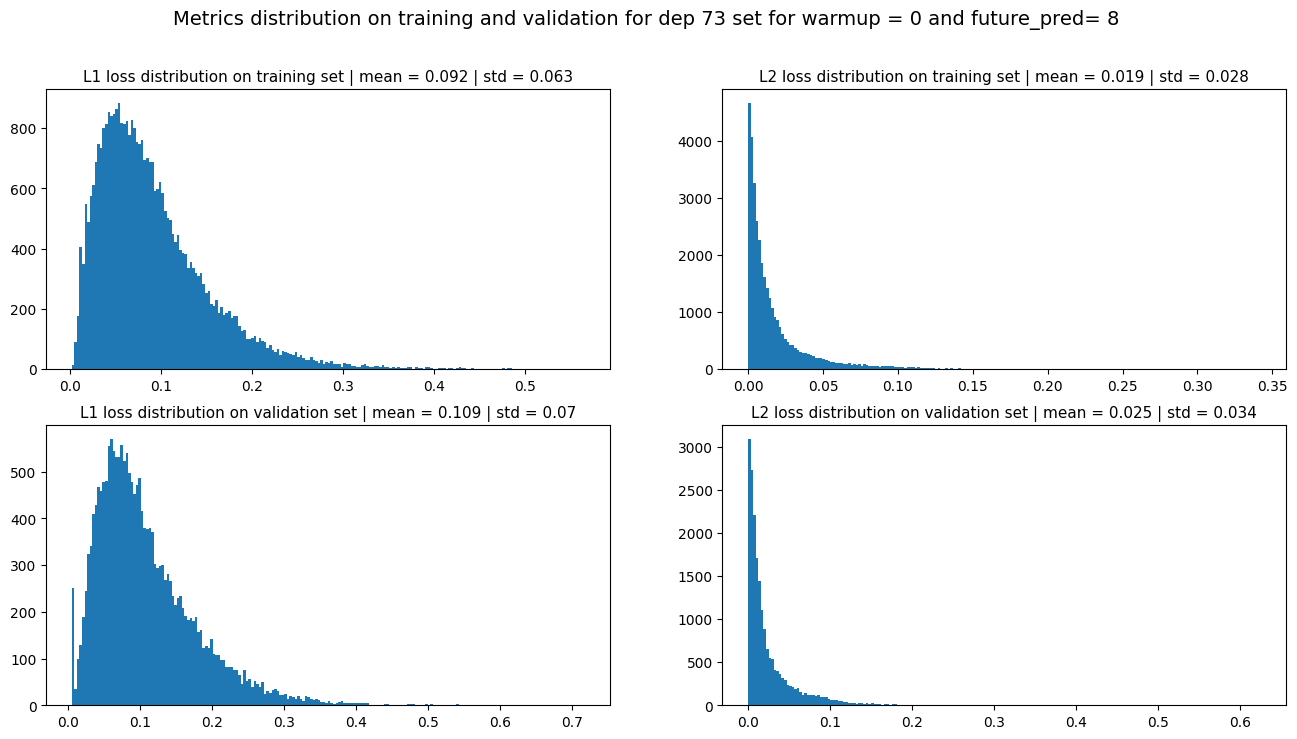

In [ ]:
l_t=np.array(L_t_e)
l_v=np.array(L_v_e)
fig,axs=plt.subplots(2,2,figsize=(16,8))
axs[0,0].hist(l_t[:,0],bins=200)
axs[0,0].set_title("L1 loss distribution on training set | mean = {} | std = {}".format(np.round(np.mean(l_t[:,0]),3),np.round(np.std(l_t[:,0]),3)), fontsize=11)
axs[0,1].hist(l_t[:,1],bins=200)
axs[0,1].set_title("L2 loss distribution on training set | mean = {} | std = {}".format(np.round(np.mean(l_t[:,1]),3),np.round(np.std(l_t[:,1]),3)), fontsize=11)
axs[1,0].hist(l_v[:,0],bins=200)
axs[1,0].set_title("L1 loss distribution on validation set | mean = {} | std = {}".format(np.round(np.mean(l_v[:,0]),3),np.round(np.std(l_v[:,0]),3)), fontsize=11)
axs[1,1].hist(l_v[:,1],bins=200)
axs[1,1].set_title("L2 loss distribution on validation set | mean = {} | std = {}".format(np.round(np.mean(l_v[:,1]),3),np.round(np.std(l_v[:,1]),3)), fontsize=11)
fig.suptitle("Metrics distribution on training and validation for dep {} set for warmup = {} and future_pred= {}".format(dep,warmup,future_prediction), fontsize=14)
plt.savefig("./media/{}_{}_{}.png".format(dep,warmup,future_prediction))
plt.show()